In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init

from flows import MAF
from models import NormalizingFlowModel

## Load and process the data

In [2]:
mode = 'ROC'

In [3]:
f_rnd = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")

In [4]:
if mode == 'ROC':
    dt = f_rnd.values
else:
    dt_PureBkg = f_PureBkg.values

In [5]:
correct = (dt[:,3]>20) &(dt[:,19]>20) & (dt[:, 4] > 0)& (dt[:, 5] > 0)& (dt[:, 6] > 0)& (dt[:, 7] > 0)& (dt[:, 8] > 0) & (dt[:, 20] > 0)& (dt[:, 21] > 0)& (dt[:, 22] > 0)& (dt[:, 23] > 0)& (dt[:, 24] > 0) & (dt[:, 25] > 0)& (dt[:, 26] > 0)


In [6]:
dt = dt[correct]

In [7]:
dt.shape

(1092753, 36)

In [8]:
for i in [4,5,6,7,8,9,10, 20, 21, 22, 23, 24, 25,26]:
    #X[:,i] = (X[:,i]-np.mean(X[:,i]))/np.std(X[:,i])
    dt[:,i] = ((dt[:,i]-np.min(dt[:,i]))/(np.max(dt[:,i])-np.min(dt[:,i])))

In [9]:
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

In [10]:
for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])

In [11]:
for i in [11,27,12,28,3,19]:
    dt[:,i] = (dt[:,i]-np.min(dt[:,i]))/(np.max(dt[:,i])-np.min(dt[:,i]))

In [12]:
X = dt[:,3:34]

In [13]:
for i in range(31):
    X[:,i] = (X[:,i]-np.mean(X[:,i]))/np.std(X[:,i])

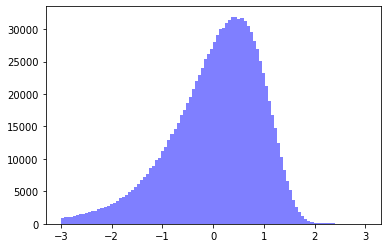

In [14]:
bins = np.linspace(-3,3,101)
plt.hist(X[:,22],bins,alpha=0.5,color='b');

In [15]:
idx = dt[:,-1]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]

In [16]:
total_PureBkg = torch.tensor(X[bkg_idx])
total_PureBkg_selection = total_PureBkg

In [17]:
total_PureBkg_selection.shape

torch.Size([992924, 31])

In [18]:
bs = 2000
bkgAE_train_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs, shuffle=True) 
bkgAE_test_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs)

## Build the model

In [19]:
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(31, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 48),
            nn.LeakyReLU(True),            
            nn.Linear(48, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 48),
            nn.LeakyReLU(True),
            nn.Linear(48, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 31)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

## Creating Instance¶

In [20]:
N_EPOCHS = 40
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

N_FLOWS = 6
Z_DIM = 6

n_steps = 0

In [21]:
model = VAE_NF(N_FLOWS, Z_DIM).cuda()

In [44]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [45]:
def train():
    global n_steps
    train_loss = []
    model.train()

    for batch_idx, x in enumerate(bkgAE_train_iterator):
        start_time = time.time()
        
        x = x.float().cuda()

        x_tilde, kl_div = model(x)
        mseloss = nn.MSELoss(size_average=False)
        #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
        loss_recons = mseloss(x_tilde,x ) / x.size(0)
        loss = loss_recons + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append([loss_recons.item(), kl_div.item()])

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                batch_idx * len(x), 50000,
                PRINT_INTERVAL * batch_idx / 50000,
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time)
            ))

        n_steps += 1

In [46]:
def evaluate(split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    model.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(bkgAE_test_iterator):
            
            x = x.float().cuda()

            x_tilde, kl_div = model(x)
            mseloss = nn.MSELoss(size_average=False)
            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss_recons = mseloss(x_tilde,x ) / x.size(0)
            loss = loss_recons + kl_div

            val_loss.append(loss.item())
            
    print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [47]:
BEST_LOSS = 99999
LAST_SAVED = -1
PATIENCE_COUNT = 0
PATIENCE_LIMIT = 5
for epoch in range(1, 1000):
    print("Epoch {}:".format(epoch))
    train()
    cur_loss = evaluate()

    if cur_loss <= BEST_LOSS:
        PATIENCE_COUNT = 0
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        if mode == 'ROC':
            torch.save(model.state_dict(),"/data/t3home000/spark/QUASAR/weights/bkg_vae_MAF_RND.h5")
        else:
            torch.save(model.state_dict(), "/data/t3home000/spark/QUASAR/weights/bkg_vae_MAF_PureBkg.h5")
    else:
        PATIENCE_COUNT += 1
        print("Not saving model! Last saved: {}".format(LAST_SAVED))
        if PATIENCE_COUNT > 5:
            print("Patience Limit Reached")
            break 

Epoch 1:

Evaluation Completed (valid)!	Loss: -49.9277 Time: 9.235 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: -50.1932 Time: 9.373 s
Saving model!
Epoch 3:

Evaluation Completed (valid)!	Loss: -50.8462 Time: 7.317 s
Saving model!
Epoch 4:

Evaluation Completed (valid)!	Loss: -51.5475 Time: 9.182 s
Saving model!
Epoch 5:

Evaluation Completed (valid)!	Loss: -52.0122 Time: 7.077 s
Saving model!
Epoch 6:

Evaluation Completed (valid)!	Loss: -52.8287 Time: 9.500 s
Saving model!
Epoch 7:

Evaluation Completed (valid)!	Loss: -53.3356 Time: 9.724 s
Saving model!
Epoch 8:

Evaluation Completed (valid)!	Loss: -54.1920 Time: 9.185 s
Saving model!
Epoch 9:

Evaluation Completed (valid)!	Loss: 235.8091 Time: 8.070 s
Not saving model! Last saved: 8
Epoch 10:

Evaluation Completed (valid)!	Loss: -50.4881 Time: 9.330 s
Not saving model! Last saved: 8
Epoch 11:

Evaluation Completed (valid)!	Loss: -50.5990 Time: 7.654 s
Not saving model! Last saved: 8
Epoch 12:

Evaluation Completed

In [48]:
model.load_state_dict(torch.load("/data/t3home000/spark/QUASAR/weights/bkg_vae_MAF_RND.h5"))

<All keys matched successfully>

## Testing with the trained model

In [49]:
def get_loss(dt):
    print(dt.shape)
    
    #for i in index_list:
    #    print(i)
    #    dt[:,i] = (dt[:,i]-np.mean(dt[:,i]))/np.std(dt[:,i])
  
    
    total_in = torch.tensor(dt)
    #total_in_train_x_1 = total_in.t()[0:6].t()
    #total_in_train_x_3 = total_in.t()[7:13].t()
    total_in_selection = total_in
    #z_mu, z_var  = model.enc(total_in_selection.float().cuda())
    #x_sample, z_mu, z_var = model(total_in_selection.float().cuda())
    #std = torch.exp(z_var / 2)
    #eps = torch.randn_like(std)
    #x_sample = eps.mul(std).add_(z_mu)
    #decoded_bkg = model.dec(x_sample)
    #recon_loss = np.zeros(len(dt),dtype=np.float)
    #for i in range(len(dt)):
    #    recon_loss[i] = F.binary_cross_entropy(x_sample[i].float().cuda(), total_in_selection[i].float().cuda(), size_average=False).data.cpu().numpy()
    
    #loss_bkg = torch.mean((x_sample.float().cuda()-total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()


    
    with torch.no_grad():
         #reconstruction loss
        #x_sample, z_mu, z_var = model(total_in_selection.float().cuda())
        #recon_loss = F.binary_cross_entropy(x_sample, total_in_selection.float().cuda(), size_average=False, reduce=None)
        

        #kl divergence loss
        #kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        #total loss
        #loss = recon_loss + kl_loss
        loss = torch.sum((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    return loss

In [50]:
out = model(torch.tensor(X[bkg_idx]).float().cuda())[0]
out = out.data.cpu().numpy()

In [51]:
out.shape

(992924, 31)

In [52]:
out2 = model(torch.tensor(X[signal_idx]).float().cuda())[0]
out2 = out2.data.cpu().numpy()


j1 M_sdb2


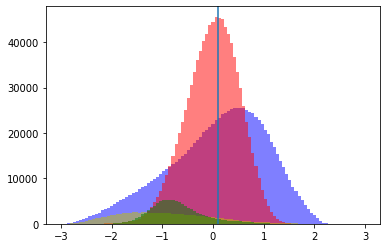

In [80]:
bins = np.linspace(-3,3,100)
bins.shape
column = 17
print(f_rnd.columns[column])
plt.hist(X[bkg_idx,column],bins,alpha=0.5,color='b');
plt.hist(out[:,column],bins,alpha=0.5,color='r');
plt.hist(X[signal_idx,column],bins,alpha=0.5,color='y');
plt.hist(out2[:,column],bins,alpha=0.5,color='g');
plt.axvline(np.mean(X[bkg_idx,column]))

#### 

In [19]:
def get_mass_and_loss(inputstring):
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    dt_in[:,1] = (dt_in[:,1]-np.mean(dt_in[:,1]))/np.std(dt_in[:,1])
    dt_in[:,2] = (dt_in[:,2]-np.mean(dt_in[:,2]))/np.std(dt_in[:,2])
    dt_in[:,3] = (dt_in[:,3]-np.mean(dt_in[:,3]))/np.std(dt_in[:,3])
    dt_in[:,4] = (dt_in[:,4]-np.mean(dt_in[:,4]))/np.std(dt_in[:,4])
    dt_in[:,5] = (dt_in[:,5]-np.mean(dt_in[:,5]))/np.std(dt_in[:,5])
    dt_in[:,6] = (dt_in[:,6]-np.mean(dt_in[:,6]))/np.std(dt_in[:,6])

    dt_in[:,8] = (dt_in[:,8]-np.mean(dt_in[:,8]))/np.std(dt_in[:,8])
    dt_in[:,9] = (dt_in[:,9]-np.mean(dt_in[:,9]))/np.std(dt_in[:,9])
    dt_in[:,10] = (dt_in[:,10]-np.mean(dt_in[:,10]))/np.std(dt_in[:,10])
    dt_in[:,11] = (dt_in[:,11]-np.mean(dt_in[:,11]))/np.std(dt_in[:,11])
    dt_in[:,12] = (dt_in[:,12]-np.mean(dt_in[:,12]))/np.std(dt_in[:,12])

    dt_in[:,14] = (dt_in[:,14]-np.mean(dt_in[:,14]))/np.std(dt_in[:,14])
    dt_in[:,15] = (dt_in[:,15]-np.mean(dt_in[:,15]))/np.std(dt_in[:,15])
    dt_in[:,16] = (dt_in[:,16]-np.mean(dt_in[:,16]))/np.std(dt_in[:,16])
    dt_in[:,17] = (dt_in[:,17]-np.mean(dt_in[:,17]))/np.std(dt_in[:,17])
    dt_in[:,18] = (dt_in[:,18]-np.mean(dt_in[:,18]))/np.std(dt_in[:,18])
    dt_in[:,19] = (dt_in[:,19]-np.mean(dt_in[:,19]))/np.std(dt_in[:,19])
    
    dt_in[:,21] = (dt_in[:,21]-np.mean(dt_in[:,21]))/np.std(dt_in[:,21])
    dt_in[:,22] = (dt_in[:,22]-np.mean(dt_in[:,22]))/np.std(dt_in[:,22])
    dt_in[:,23] = (dt_in[:,23]-np.mean(dt_in[:,23]))/np.std(dt_in[:,23])
    dt_in[:,24] = (dt_in[:,24]-np.mean(dt_in[:,24]))/np.std(dt_in[:,24])
    dt_in[:,25] = (dt_in[:,25]-np.mean(dt_in[:,25]))/np.std(dt_in[:,25])   
    
    total_in = torch.tensor(dt_in)
    total_in_train_x_1 = total_in.t()[1:7].t()
    total_in_train_x_2 = total_in.t()[8:13].t()
    total_in_train_x_3 = total_in.t()[14:20].t()
    total_in_train_x_4 = total_in.t()[21:26].t()
    total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_2,total_in_train_x_3,total_in_train_x_4),dim=1)
    
    with torch.no_grad():
        loss_total_in = torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    
    return dt_in[:,0], dt_in[:,10], dt_in[:,23], dt_in[:,9], dt_in[:,22], loss_total_in

In [ ]:
def get_mass(inputstring):

    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    
    return dt_in[:,0]

In [ ]:
bb2mass = get_mass("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_BB1.h5")
purebkgmass = get_mass("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_pureBkg.h5")

In [ ]:
bb2mass, bb2mmdt1, bb2mmdt2, bb2prun1,bb2prun2, bb2loss = get_mass_and_loss("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_BB1.h5")
purebkgmass, purebkgmmdt1, purebkgmmdt2, purebkgprun1,purebkgprun2, purebkgloss = get_mass_and_loss("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_pureBkg.h5")

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,5,1100)
plt.hist(bb2loss,bins=bins,alpha=0.3,color='b',label='blackbox1')
plt.hist(purebkgloss,bins=bins,alpha=0.3,color='r',label='background')
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [20]:
def get_loss(dt_in):

    #dt_in[:,1] = (dt_in[:,1]-np.mean(dt_in[:,1]))/np.std(dt_in[:,1])
    #dt_in[:,2] = (dt_in[:,2]-np.mean(dt_in[:,2]))/np.std(dt_in[:,2])
    #dt_in[:,3] = (dt_in[:,3]-np.mean(dt_in[:,3]))/np.std(dt_in[:,3])
    #dt_in[:,4] = (dt_in[:,4]-np.mean(dt_in[:,4]))/np.std(dt_in[:,4])
    #dt_in[:,5] = (dt_in[:,5]-np.mean(dt_in[:,5]))/np.std(dt_in[:,5])
    #dt_in[:,6] = (dt_in[:,6]-np.mean(dt_in[:,6]))/np.std(dt_in[:,6])

    #dt_in[:,8] = (dt_in[:,8]-np.mean(dt_in[:,8]))/np.std(dt_in[:,8])
    #dt_in[:,9] = (dt_in[:,9]-np.mean(dt_in[:,9]))/np.std(dt_in[:,9])
    #dt_in[:,10] = (dt_in[:,10]-np.mean(dt_in[:,10]))/np.std(dt_in[:,10])
    #dt_in[:,11] = (dt_in[:,11]-np.mean(dt_in[:,11]))/np.std(dt_in[:,11])
    #dt_in[:,12] = (dt_in[:,12]-np.mean(dt_in[:,12]))/np.std(dt_in[:,12])

    #dt_in[:,14] = (dt_in[:,14]-np.mean(dt_in[:,14]))/np.std(dt_in[:,14])
    #dt_in[:,15] = (dt_in[:,15]-np.mean(dt_in[:,15]))/np.std(dt_in[:,15])
    #dt_in[:,16] = (dt_in[:,16]-np.mean(dt_in[:,16]))/np.std(dt_in[:,16])
    #dt_in[:,17] = (dt_in[:,17]-np.mean(dt_in[:,17]))/np.std(dt_in[:,17])
    #dt_in[:,18] = (dt_in[:,18]-np.mean(dt_in[:,18]))/np.std(dt_in[:,18])
    #dt_in[:,19] = (dt_in[:,19]-np.mean(dt_in[:,19]))/np.std(dt_in[:,19])
    
    #dt_in[:,21] = (dt_in[:,21]-np.mean(dt_in[:,21]))/np.std(dt_in[:,21])
    #dt_in[:,22] = (dt_in[:,22]-np.mean(dt_in[:,22]))/np.std(dt_in[:,22])
    #dt_in[:,23] = (dt_in[:,23]-np.mean(dt_in[:,23]))/np.std(dt_in[:,23])
    #dt_in[:,24] = (dt_in[:,24]-np.mean(dt_in[:,24]))/np.std(dt_in[:,24])
    #dt_in[:,25] = (dt_in[:,25]-np.mean(dt_in[:,25]))/np.std(dt_in[:,25])   
    
    total_in = torch.tensor(dt_in)
    total_in_train_x_1 = total_in.t()[1:7].t()
    total_in_train_x_2 = total_in.t()[8:13].t()
    total_in_train_x_3 = total_in.t()[14:20].t()
    total_in_train_x_4 = total_in.t()[21:26].t()
    #total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_2,total_in_train_x_3,total_in_train_x_4),dim=1)
    total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_3),dim=1)
    
    with torch.no_grad():
        loss_total_in = torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    return loss_total_in

In [21]:
loss_bkg = get_loss(dt_PureBkg[bkg_idx])
loss_sig = get_loss(dt_PureBkg[signal_idx])

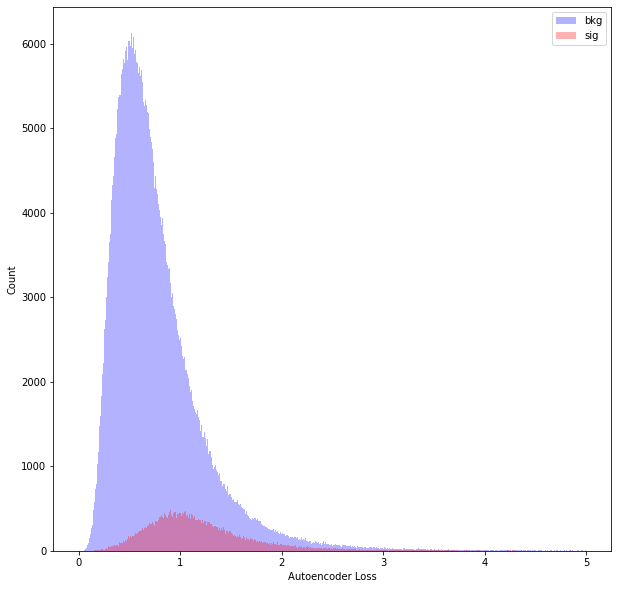

In [22]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,5,1100)
plt.hist(loss_bkg,bins=bins,alpha=0.3,color='b',label='bkg')
plt.hist(loss_sig,bins=bins,alpha=0.3,color='r',label='sig')
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [23]:
np.save('MAF_bkgae_sigloss.npy',loss_sig)
np.save('MAF_bkgae_bkgloss.npy',loss_bkg)